<a href="https://colab.research.google.com/github/aparnashenoy/ml/blob/master/xgboost_regressor_version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of time difference using linear Regression and ensemble learning algorithm

The AIS provides vessels' static and dynamic information, which is crucial for vessel traffic situation awareness. However, AIS transponders can be switched off to hide suspecious activities. In this study, we use the real time AIS data to analyse the possibility os successfull detection of intentional and non-intentional AIS on-off switching anomalies. We extract the vessel timestamp, position, speed and course from the AIS data for the study.

# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
path = '/gdrive/My Drive/'

In [3]:
#Data Manipulation
import pandas as pd
import numpy as np

#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Feature Engineering
from sklearn.preprocessing import LabelEncoder

# Model and evaluation
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Import dataset

The dataset is downloaded from maritime cadastre for this study. The dataset includes AIS messages from June 1 - June 5, 2022. the features extracted for the study are MMSI, BaseDateTime, LAT, LON, SOG, COG, VesselType, TransceiverClass. The missing values were removed. The region of study was captured using geopandas library.

In [4]:
df = pd.read_csv(path +'gdf.csv')

In [5]:
df.drop(['MMSI_length', 'geometry'], axis=1, inplace=True)

In [6]:
df.head(20)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselType,TransceiverClass
0,366999387,2022-06-01 00:00:02,32.16739,-92.10980,0.0,274.9,511.0,90.0,A
1,366999387,2022-06-01 00:01:05,32.16737,-92.10980,0.0,261.8,511.0,90.0,A
2,366999387,2022-06-01 00:02:06,32.16736,-92.10977,0.0,252.3,511.0,90.0,A
3,366999387,2022-06-01 00:03:09,32.16734,-92.10978,0.0,249.2,511.0,90.0,A
4,366999387,2022-06-01 00:04:10,32.16737,-92.10978,0.0,246.8,511.0,90.0,A
5,366999387,2022-06-01 00:05:13,32.16730,-92.10976,0.0,247.7,511.0,90.0,A
6,366999387,2022-06-01 00:06:15,32.16741,-92.10980,0.0,258.2,511.0,90.0,A
7,366999387,2022-06-01 00:07:17,32.16736,-92.10979,0.0,265.7,511.0,90.0,A
8,366999387,2022-06-01 00:08:19,32.16737,-92.10978,0.0,273.4,511.0,90.0,A
9,366999387,2022-06-01 00:09:20,32.16736,-92.10979,0.0,280.4,511.0,90.0,A


# Description of the dataset
The dataset includes 26470 observations and 9 features. The features and the initial datatypes are tabulated below.

In [7]:
df.shape

(26470, 9)

In [8]:
df.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselType', 'TransceiverClass'],
      dtype='object')

In [9]:
# datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26470 entries, 0 to 26469
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MMSI              26470 non-null  int64  
 1   BaseDateTime      26470 non-null  object 
 2   LAT               26470 non-null  float64
 3   LON               26470 non-null  float64
 4   SOG               26470 non-null  float64
 5   COG               26470 non-null  float64
 6   Heading           26470 non-null  float64
 7   VesselType        26470 non-null  float64
 8   TransceiverClass  26470 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 1.8+ MB


The feature MMSI and TransceiverClass are converted to category for analysis purpose

In [10]:
#datatypes conversion
df = df.astype({"MMSI":'category', "TransceiverClass":'category'})

In [11]:
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselType,TransceiverClass
0,366999387,2022-06-01 00:00:02,32.16739,-92.10980,0.0,274.9,511.0,90.0,A
1,366999387,2022-06-01 00:01:05,32.16737,-92.10980,0.0,261.8,511.0,90.0,A
2,366999387,2022-06-01 00:02:06,32.16736,-92.10977,0.0,252.3,511.0,90.0,A
3,366999387,2022-06-01 00:03:09,32.16734,-92.10978,0.0,249.2,511.0,90.0,A
4,366999387,2022-06-01 00:04:10,32.16737,-92.10978,0.0,246.8,511.0,90.0,A
...,...,...,...,...,...,...,...,...,...
26465,368179250,2022-06-05 23:55:38,25.76767,-80.14428,7.8,117.1,125.0,20.0,A
26466,368179250,2022-06-05 23:56:41,25.76641,-80.14321,4.7,170.3,180.0,20.0,A
26467,368179250,2022-06-05 23:57:45,25.76536,-80.14329,3.2,199.5,224.0,20.0,A
26468,368179250,2022-06-05 23:58:48,25.76467,-80.14410,1.6,223.8,217.0,20.0,A


# Captured MMSI for the study
In the pilot study, following MMSIs had the largest timestamp entries where AIS messages were sent every minute in a particular geographical area.

In [12]:
# identify the unique MMSIs with count
df.MMSI.value_counts()

366999387    6732
368179250    6597
367458840    6586
367314530    6555
Name: MMSI, dtype: int64

In [13]:
# filter the dataset with speed greater than 0 knots
df = df[df['SOG']>0.0]

In [14]:
#conversion of BaseDateTime variable as Datetime64 datatype for time series analysis
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

<ipython-input-14-b80b5152c476>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])


# Time Difference calculation
The function below calculates the difference in the consecutive timestamps for unique MMSIs. A new column is created which provides the time difference between consecutive timestamps.

In [15]:
def apply_time_difference(data):
    data['time_diff'] = data.sort_values(['MMSI', 'BaseDateTime'], ascending = True).groupby('MMSI')['BaseDateTime'].diff(1).dt.floor('T').dt.total_seconds().div(60).fillna(0)

In [16]:
apply_time_difference(df)

<ipython-input-15-991746702e16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_diff'] = data.sort_values(['MMSI', 'BaseDateTime'], ascending = True).groupby('MMSI')['BaseDateTime'].diff(1).dt.floor('T').dt.total_seconds().div(60).fillna(0)


In [17]:
df = df.astype({'time_diff': 'int'})

In [18]:
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselType,TransceiverClass,time_diff
86,366999387,2022-06-01 01:27:51,32.16739,-92.10974,0.1,219.4,511.0,90.0,A,0
363,366999387,2022-06-01 06:09:19,32.16729,-92.10976,0.1,273.6,511.0,90.0,A,281
470,366999387,2022-06-01 07:58:57,32.16736,-92.10975,0.1,244.6,511.0,90.0,A,109
596,366999387,2022-06-01 10:07:17,32.16735,-92.10977,0.1,231.3,511.0,90.0,A,128
627,366999387,2022-06-01 10:39:19,32.16736,-92.10979,0.1,226.3,511.0,90.0,A,32
...,...,...,...,...,...,...,...,...,...,...
26465,368179250,2022-06-05 23:55:38,25.76767,-80.14428,7.8,117.1,125.0,20.0,A,1
26466,368179250,2022-06-05 23:56:41,25.76641,-80.14321,4.7,170.3,180.0,20.0,A,1
26467,368179250,2022-06-05 23:57:45,25.76536,-80.14329,3.2,199.5,224.0,20.0,A,1
26468,368179250,2022-06-05 23:58:48,25.76467,-80.14410,1.6,223.8,217.0,20.0,A,1


In [19]:
df = df.set_index('BaseDateTime')

In [20]:
df.to_csv('data_time_diff.csv', index = False)

# Time Difference for 5 days dataset including 4 MMSIs
From the graph below we can that the main density of time difference is 1 to 5 minutes or 10 minutes

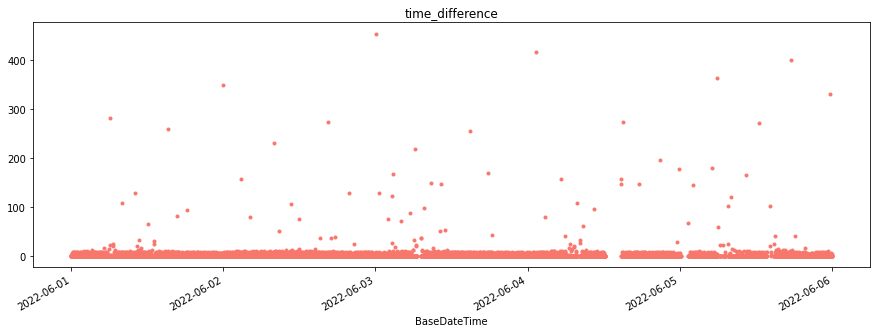

In [21]:
df.time_diff.plot(style = '.', figsize = (15,5), color = "#F8776D", title = 'time_difference');

# Time Difference for individual MMSI for a given LAT and LON
Among all the 4 MMSIs used in the pilot study, all the MMSIs showed a delay in time difference all the 5 days.

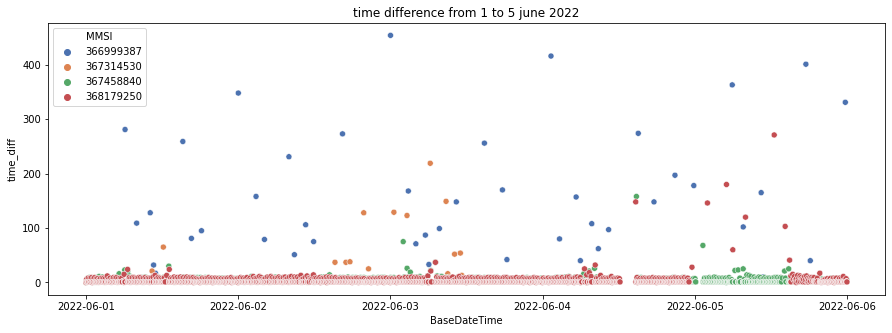

In [22]:
fig, ax = plt.subplots(figsize = (15,5))
sns.scatterplot(data= df, x= df.index, y='time_diff', hue = 'MMSI', palette = 'deep')
ax.set_title('time difference from 1 to 5 june 2022')
plt.show()

In [23]:
#create new feature hour and day of the week at which the message was received
def create_feature(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] =df.index.minute
    df['dayofweek'] = df.index.dayofweek
    return df

In [24]:
create_feature(df)

,MMSI,LAT,LON,SOG,COG,Heading,VesselType,TransceiverClass,time_diff,hour,minute,dayofweek
BaseDateTime,,,,,,,,,,,,
2022-06-01 01:27:51,366999387,32.16739,-92.10974,0.1,219.4,511.0,90.0,A,0,1,27,2
2022-06-01 06:09:19,366999387,32.16729,-92.10976,0.1,273.6,511.0,90.0,A,281,6,9,2
2022-06-01 07:58:57,366999387,32.16736,-92.10975,0.1,244.6,511.0,90.0,A,109,7,58,2
2022-06-01 10:07:17,366999387,32.16735,-92.10977,0.1,231.3,511.0,90.0,A,128,10,7,2
2022-06-01 10:39:19,366999387,32.16736,-92.10979,0.1,226.3,511.0,90.0,A,32,10,39,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-05 23:55:38,368179250,25.76767,-80.14428,7.8,117.1,125.0,20.0,A,1,23,55,6
2022-06-05 23:56:41,368179250,25.76641,-80.14321,4.7,170.3,180.0,20.0,A,1,23,56,6
2022-06-05 23:57:45,368179250,25.76536,-80.14329,3.2,199.5,224.0,20.0,A,1,23,57,6


In [25]:
df.columns

Index(['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType',
       'TransceiverClass', 'time_diff'],
      dtype='object')

# Time difference for 1 June 2022
From the graph below, we can observe that the AIS messages were recieved with a lot of difference in the time stamp. 

In [26]:
df_1june = df[df.index <= '2022-06-02 00:00:00'].head(20)

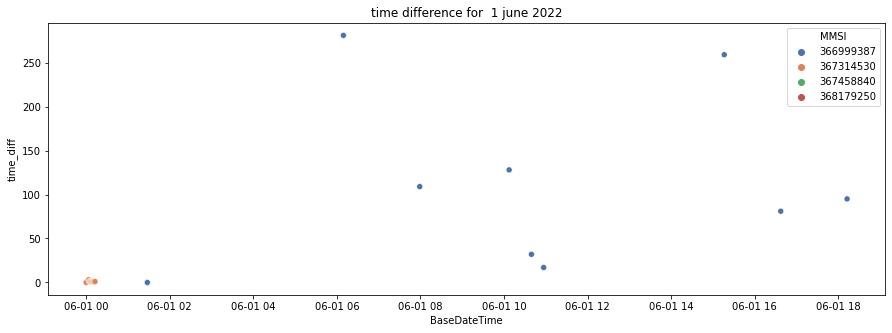

In [27]:
fig, ax = plt.subplots(figsize = (15,5))
sns.scatterplot(data= df_1june, x= df_1june.index, y='time_diff', hue = 'MMSI', palette ='deep')
ax.set_title('time difference for  1 june 2022')
plt.show()

In [28]:
le = LabelEncoder()
df['TransceiverClass'] = le.fit_transform(df['TransceiverClass'])

# Train/Test Split
In this study, we have split the data into train from 1 to 3 June 2022 and 4 to 5 June 2022 as test data. 

In [29]:
train = df.loc[df.index < '2022-06-04 00:00:00']
test = df.loc[df.index >= '2022-06-04 00:00:00']

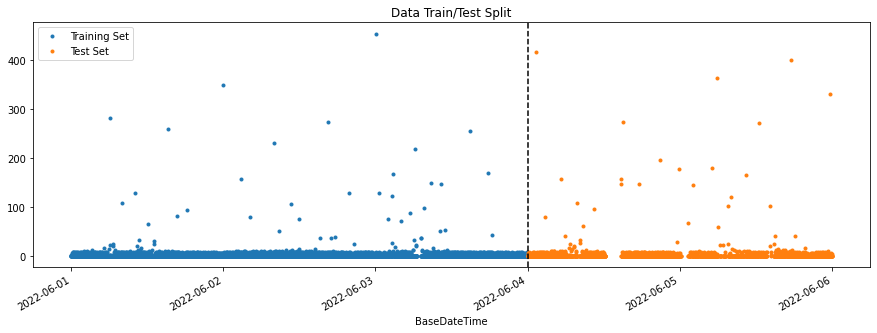

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
train['time_diff'].plot(ax=ax, label = 'Training Set', title = 'Data Train/Test Split', style = '.')
test['time_diff'].plot(ax=ax, label = 'Test Set', style ='.')
ax.axvline('2022-06-04 00:00:00', color ='black', ls ='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

create new features from our data

In [31]:
train = create_feature(train)
test = create_feature(test)

Predictor features and target features are defined 

In [32]:
FEATURES = ['LAT', 'LON', 'SOG', 'COG', 'TransceiverClass', 'hour','minute', 'dayofweek']
TARGET = 'time_diff'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Model Fitting

# XGBoost Regressor Algorithm

XGBoost or extreme gradient boosting is a well known ensemble learning algorithm having enhanced performance and speed in tree-based machine learning algorithms. Ensemble learning consists of a collection of predictors which are multiple models to provide better prediction accuracy. In the boosting algorithms, the errors made by previous models are corrected by the succeeding models by adding some weights to the models.
## Features of XGBoost
1. Can be executed on both single and distributed systems.
2. Supports parallel processing
3. Cache optimization
4. Efficient memory management for large datasets exceeding RAM.
5. Consists of a variety of regularization techniques to reduce model overfitting.
6. Can handle missing values.
7. Consists of built-in cross validation.
10. Handles outliers.

## Using XGBoost Regressor for time series analysis
When we discuss about time series analysis and forecasting, we generally use traditional models such as ARIMA (Autoregressive integrated moving average) models where the model focuses on regression analysis and if we can perform this regression with this technique we can acheive a state of the art performance in the time series modeling. Similarly, ensemble of weak machine learning models can also help us to perform time series modeling.


# Instantiating the model

In [33]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)


# Fitting the data into the model

In [34]:
reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose =100)

[13:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:12.6954	validation_1-rmse:22.1179
[100]	validation_0-rmse:8.58529	validation_1-rmse:18.5762
[200]	validation_0-rmse:7.11851	validation_1-rmse:17.9883
[300]	validation_0-rmse:6.7969	validation_1-rmse:17.9495
[400]	validation_0-rmse:6.79616	validation_1-rmse:17.9463
[500]	validation_0-rmse:6.79606	validation_1-rmse:17.9451
[600]	validation_0-rmse:6.79605	validation_1-rmse:17.9447
[700]	validation_0-rmse:6.79605	validation_1-rmse:17.9446
[800]	validation_0-rmse:6.79605	validation_1-rmse:17.9445
[900]	validation_0-rmse:6.79605	validation_1-rmse:17.9445
[999]	validation_0-rmse:6.79606	validation_1-rmse:17.9445


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

Before making predictions on the test data we can also follow the process of feature selection. In this process, we can use the feature importance technique. This process 

In [35]:
#feature_importance = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
#feature_importance.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
#plt.show()

In [36]:
test['prediction'] = reg.predict(X_test)

In [37]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [38]:
df

,MMSI,LAT,LON,SOG,COG,Heading,VesselType,TransceiverClass,time_diff,prediction
BaseDateTime,,,,,,,,,,
2022-06-01 00:00:01,367314530,37.60087,-76.37251,7.0,116.9,511.0,31.0,0,0,NaN
2022-06-01 00:00:01,368179250,25.76419,-80.14437,0.9,177.8,178.0,20.0,0,0,NaN
2022-06-01 00:01:06,367458840,25.77179,-80.15139,0.7,252.3,291.0,60.0,0,0,NaN
2022-06-01 00:02:07,367458840,25.77149,-80.15241,5.7,189.7,152.0,60.0,0,1,NaN
2022-06-01 00:03:09,367458840,25.77033,-80.15043,9.0,111.3,297.0,60.0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-06-05 23:56:41,368179250,25.76641,-80.14321,4.7,170.3,180.0,20.0,0,1,1.628316
2022-06-05 23:57:45,368179250,25.76536,-80.14329,3.2,199.5,224.0,20.0,0,1,1.752545
2022-06-05 23:58:44,367458840,25.77179,-80.15138,0.1,360.0,295.0,60.0,0,5,6.268676


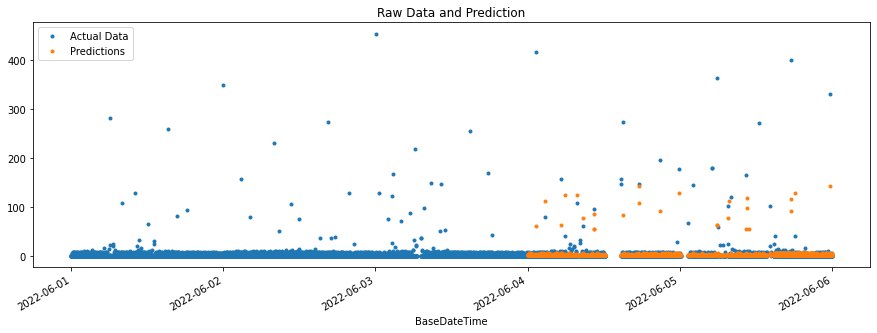

In [39]:
ax = df[['time_diff']].plot(figsize = (15,5), style = '.')
df['prediction'].plot(ax=ax, style = '.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [40]:
import numpy as np
score = np.sqrt(mean_squared_error(test['time_diff'], test['prediction']))
print(f'RMSE Score on test set :{score:0.2f}')

RMSE Score on test set :17.94


In [41]:
test['error'] =np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending = False).head()

date
2022-06-05    4.371903
2022-06-04    2.654738
Name: error, dtype: float64

In [42]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [43]:
score = reg.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.710007991766574


In [44]:
ypred = reg.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

MSE: 322.01


In [45]:
lin_reg = LinearRegression()

In [46]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [47]:
test['prediction_linear_regression'] = lin_reg.predict(X_test)

In [48]:
df = df.merge(test[['prediction_linear_regression']], how='left', left_index=True, right_index=True)

In [49]:
df

,MMSI,LAT,LON,SOG,COG,Heading,VesselType,TransceiverClass,time_diff,prediction,prediction_linear_regression
BaseDateTime,,,,,,,,,,,
2022-06-01 00:00:01,367314530,37.60087,-76.37251,7.0,116.9,511.0,31.0,0,0,NaN,NaN
2022-06-01 00:00:01,368179250,25.76419,-80.14437,0.9,177.8,178.0,20.0,0,0,NaN,NaN
2022-06-01 00:01:06,367458840,25.77179,-80.15139,0.7,252.3,291.0,60.0,0,0,NaN,NaN
2022-06-01 00:02:07,367458840,25.77149,-80.15241,5.7,189.7,152.0,60.0,0,1,NaN,NaN
2022-06-01 00:03:09,367458840,25.77033,-80.15043,9.0,111.3,297.0,60.0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-05 23:56:41,368179250,25.76641,-80.14321,4.7,170.3,180.0,20.0,0,1,1.628316,2.594338
2022-06-05 23:57:45,368179250,25.76536,-80.14329,3.2,199.5,224.0,20.0,0,1,1.752545,2.932618
2022-06-05 23:58:44,367458840,25.77179,-80.15138,0.1,360.0,295.0,60.0,0,5,6.268676,3.758041


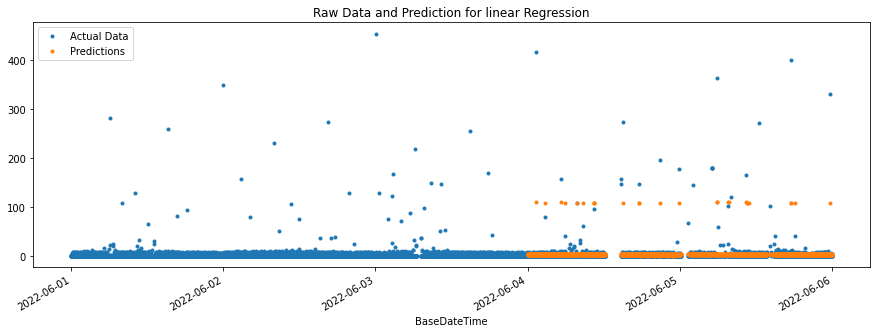

In [50]:
ax = df[['time_diff']].plot(figsize = (15,5), style = '.')
df['prediction_linear_regression'].plot(ax=ax, style = '.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Prediction for linear Regression')
plt.show()

In [51]:
score = np.sqrt(mean_squared_error(test['time_diff'], test['prediction_linear_regression']))
print(f'RMSE Score on test set :{score:0.2f}')

RMSE Score on test set :17.58


In [52]:
score = lin_reg.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.4002868076005517


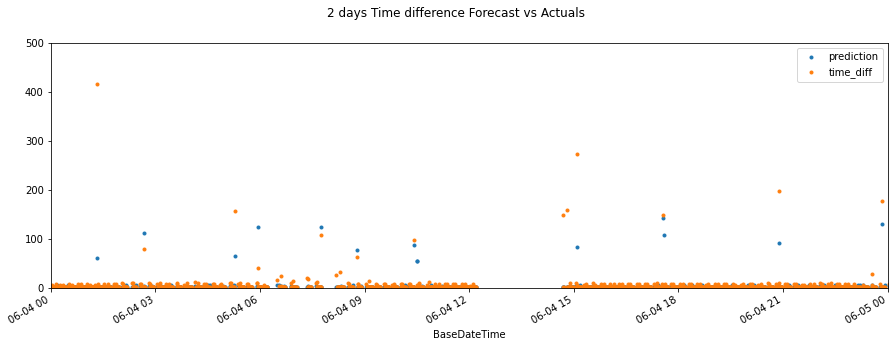

In [53]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df[['prediction','time_diff']].plot(ax=ax,
                                              style=['.','.'])
ax.set_xbound(lower='2022-06-04 00:00:00', upper='2022-06-05 00:00:00')
ax.set_ylim(0, 500)
plot = plt.suptitle('2 days Time difference Forecast vs Actuals')

In [58]:
test['error'] =np.abs(test[TARGET] - test['prediction'])
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['MMSI', 'LAT','LON',
       'date' ])\
.mean()[['time_diff','prediction','error','abs_error']]

In [60]:
error_by_day.sort_values('error', ascending=True).head(10).reset_index()

,MMSI,LAT,LON,date,time_diff,prediction,error,abs_error
0,367458840,25.76601,-80.14427,2022-06-05,2.0,2.013028,0.013028,0.013028
1,367458840,25.77176,-80.15160,2022-06-04,2.0,1.974479,0.025521,0.025521
2,367458840,25.76444,-80.14436,2022-06-04,3.0,2.893989,0.106011,0.106011
3,367458840,25.76412,-80.14438,2022-06-05,2.0,1.858058,0.141942,0.141942
4,367458840,25.77119,-80.15135,2022-06-04,2.0,1.737209,0.262791,0.262791
5,367458840,25.77094,-80.15084,2022-06-05,2.0,1.648609,0.351391,0.351391
6,367458840,25.76958,-80.14826,2022-06-05,2.0,1.648609,0.351391,0.351391
7,367458840,25.76951,-80.14751,2022-06-05,2.0,1.648609,0.351391,0.351391
8,368179250,25.77003,-80.15007,2022-06-04,1.0,1.628316,0.628316,0.628316
9,367458840,25.76795,-80.14451,2022-06-04,1.0,1.628316,0.628316,0.628316


In [61]:
test['error_linear_regression'] =np.abs(test[TARGET] - test['prediction_linear_regression'])
test['abs_error_linear_regression'] = test['error_linear_regression'].apply(np.abs)
error_by_day_linear_regression = test.groupby(['MMSI', 'LAT','LON',
       'date' ]) \
    .mean()[['time_diff','prediction_linear_regression','error_linear_regression','abs_error_linear_regression']]

In [62]:
error_by_day_linear_regression.sort_values('error_linear_regression', ascending=True).head(10).reset_index()

,MMSI,LAT,LON,date,time_diff,prediction_linear_regression,error_linear_regression,abs_error_linear_regression
0,368179250,25.77047,-80.15093,2022-06-04,1.0,1.000314,0.000314,0.000314
1,368179250,25.77078,-80.15118,2022-06-04,1.0,1.038528,0.038528,0.038528
2,368179250,25.77007,-80.15013,2022-06-04,1.0,0.953475,0.046525,0.046525
3,368179250,25.76880,-80.14661,2022-06-04,1.0,1.068577,0.068577,0.068577
4,368179250,25.76997,-80.14945,2022-06-04,1.0,1.071460,0.071460,0.071460
5,368179250,25.76864,-80.14641,2022-06-04,1.0,1.080571,0.080571,0.080571
6,368179250,25.76913,-80.14767,2022-06-04,1.0,0.916960,0.083040,0.083040
7,368179250,25.76864,-80.14638,2022-06-04,1.0,1.085322,0.085322,0.085322
8,368179250,25.76873,-80.14683,2022-06-04,1.0,0.913842,0.086158,0.086158
9,368179250,25.77013,-80.14959,2022-06-04,1.0,1.124128,0.124128,0.124128
